# Noise-accurate simulation of the Bernstein–Vazirani algorithm

The Bernstein–Vazirani (BV) algorithm [[Bernstein, Vazirani, 1993](https://doi.org/10.1137/S0097539796300921)] finds a secret bitstring $s\in\{0, 1\}^n$, knowing the function $f(x)=x\cdot s$, where $\cdot$ denotes the bit-wise dot-product and $x\in\{0, 1\}^n$.

Assuming we have a black-box oracle computing $f$, the algorithm finds $s$ in one call to the oracle, against $n$ calls for a classical algorithm.

In the following, we will estimate the success probability of the BV algorithms in the presence of noise.

## Transpilation of the algorithm

We start by generating a `qiskit` circuit implementing the BV algorithm. We use the hidden string to implement the oracle and neglect the consecutive Hadamard gates ($H^2=\mathbb{1}$).

This is clearly a toy example, as we use the hidden string to build the circuit. However, this allows us to measure the impact of noise on the result.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from qiskit.circuit import QuantumCircuit

from spin_pulse import ExperimentalEnvironment, HardwareSpecs, PulseCircuit, Shape
from spin_pulse.environment.noise import NoiseType


def gen_bv_circ(hidden_string: str | None = None) -> QuantumCircuit:
    """
    Generate the BV circuit using the hidden bitstring to create the oracle.
    We omit the Hadamard gates when there are two consecutive ones on the same qubit.
    """
    num_qubits = len(hidden_string) + 1
    circuit = QuantumCircuit(num_qubits, 0)

    # Initialize the ancilla in |1>
    circuit.x(-1)

    for i in range(num_qubits - 2, -1, -1):
        if hidden_string[num_qubits - 2 - i] == "1":
            circuit.h(i)
            circuit.cz(-1, i)
            circuit.h(i)

    return circuit

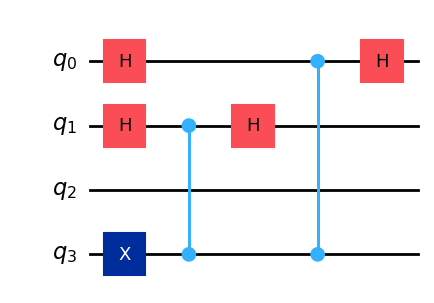

In [2]:
# Pick your string
hidden_string = "011"
num_qubits = len(hidden_string) + 1

# Ideal circuit
qc = gen_bv_circ(hidden_string)
qc.draw("mpl")

We first define our hardware specifications and use them to transpile the `qiskit` circuit according to our needs. We can apply Dynamical Decoupling (DD) on idle qubits during single-qubit unitaries by specifying the DD scheme in `HardwareSpecs`.

We then define our `PulseCircuit`s to which we attach the transpiled circuit and the hardware specifications. For the noisy case, we also attach an experimental environment that specifies the noise. Note that we deliberately chose a high level of noise to exhibit the effect of DD even on small circuits.


In [3]:
from spin_pulse import DynamicalDecoupling


def get_hdw_specs(DD):
    return HardwareSpecs(
        num_qubits=num_qubits,
        B_field=0.1,
        delta=0.1,
        J_coupling=0.01,
        rotation_shape=Shape.GAUSSIAN,
        ramp_duration=5,
        coeff_duration=5,
        dynamical_decoupling=DD,
        optim=1,
    )


hardware_specs = get_hdw_specs(None)
hardware_specs_DD = get_hdw_specs(DynamicalDecoupling.FULL_DRIVE)

# ISA circuit
isa_qc_bv = hardware_specs.gate_transpile(qc)

# Pulse circuit without noise
pulse_qc_bv_noiseless = PulseCircuit.from_circuit(isa_qc_bv, hardware_specs)

## Noise simulations

Let's define the duration of our `ExperimentalEnvironment` such that it is $n_\text{samples}$ times longer than the circuit duration. This will provide us $n_\text{samples}$ noisy circuit instances to work with.

In [4]:
n_samples = 500
duration = pulse_qc_bv_noiseless.duration * n_samples

exp_env = ExperimentalEnvironment(
    hardware_specs=hardware_specs,
    noise_type=NoiseType.PINK,
    T2S=500,
    duration=duration,
    segment_duration=duration,
    only_idle=False,
)

# Pulse circuit with noise
pulse_qc_bv_noisy = PulseCircuit.from_circuit(
    isa_qc_bv, hardware_specs, exp_env=exp_env
)

# ISA circuit with DD
isa_qc_bv_DD = hardware_specs_DD.gate_transpile(qc)
# Pulse circuit with noise and DD
pulse_qc_bv_noisy_DD = PulseCircuit.from_circuit(
    isa_qc_bv_DD, hardware_specs_DD, exp_env=exp_env
)

There exist two equivalent solutions (in the limit of an infinite number of samples) to compute our success probability.

We can simulate an experiment that performs a bitstring measurement on each realization of the noisy circuit.
Averaging over multiple realizations gives the probability distribution
$P(s)=\bra{s}\rho_f\ket{s}$, where $\rho_f$ is the density matrix of the system after running the algorithm.
In particular, for $s=s_0$ where $s_0$ denotes the hidden string, we obtain the success probability of the algorithm.

Alternatively, noting that

$$\rho_f=\mathbb{E}_u\left[u\ket{0^{\otimes N}}\bra{0^{\otimes N}} u^\dagger\right],$$

where $u$ are the matrices representing the noisy realizations of the quantum circuit, we can recast the success probability as

$$ P(s_0)=\mathbb{E}_u\left[ \left|\bra{s_0}u\ket{0^{\otimes N}}\right|^2\right],$$

and estimate it numerically by calculating the matrices $u$ explicitely, and averaging the overlap $\left|\bra{s_0}u\ket{0^{\otimes N}}\right|^2$ over many noisy circuit realizations.


### Estimating the success probability by simulating an experiment

The first option is implemented by the method `run_experiment` of the `PulseCircuit` class. It executes a single-shot measurement on each noisy instance of the circuit that can be created using the given `ExperimentalEnvironment`.
Simulations are performed using Matrix Product State (MPS) implementation by `qiskit_aer`.


In [5]:
print("Hidden string ", hidden_string)
print("Expected output in the counts ", "1" + hidden_string)

counts_pulse_qc_bv_noisy = pulse_qc_bv_noisy.run_experiment(exp_env)
print(
    "P_sucess_noise=",
    counts_pulse_qc_bv_noisy["1" + hidden_string]
    / sum(counts_pulse_qc_bv_noisy.values()),
)

counts_pulse_qc_bv_noisy_DD = pulse_qc_bv_noisy_DD.run_experiment(exp_env)
print(
    "P_sucess_noise_DD=",
    counts_pulse_qc_bv_noisy_DD["1" + hidden_string]
    / sum(counts_pulse_qc_bv_noisy_DD.values()),
)

Hidden string  011
Expected output in the counts  1011


P_sucess_noise= 0.836


P_sucess_noise_DD= 0.884


We can visualize the results with `plot_histogram` provided by `qiskit`. We observe that DD brings a significant improvement.

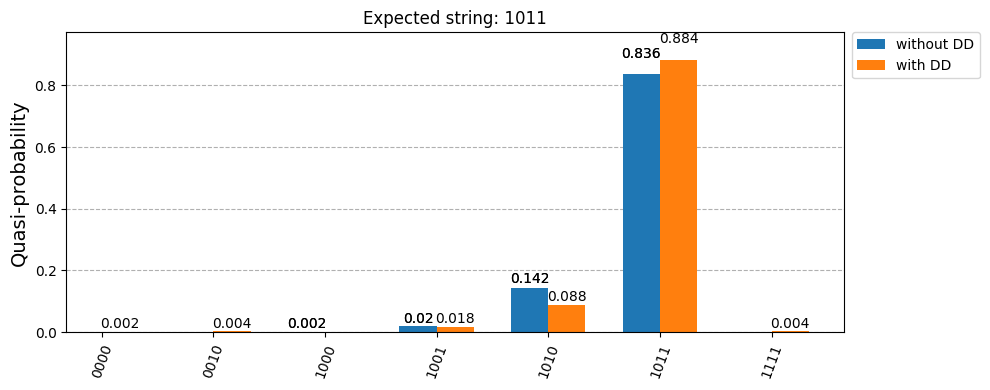

In [6]:
from qiskit.visualization import plot_histogram


def normalize_counts(counts):
    tot_sum = sum(counts.values())
    return {k: v / tot_sum for k, v in counts.items()}


normalized_counts_pulse_qc_bv_noisy = normalize_counts(counts_pulse_qc_bv_noisy)
normalized_counts_pulse_qc_bv_noisy_DD = normalize_counts(counts_pulse_qc_bv_noisy_DD)
plot_histogram(
    [normalized_counts_pulse_qc_bv_noisy, normalized_counts_pulse_qc_bv_noisy_DD],
    legend=["without DD", "with DD"],
    title=f"Expected string: 1{hidden_string}",
    figsize=(10, 4),
)

### Estimating the success probability by computing the overlap with the hidden bitstring


The second option consists in computing the overlap $\left|\bra{s_0}u\ket{0^{\otimes N}}\right|^2$ between the hidden bitstring and the state obtained after applying the circuit to $\ket{0^{\otimes N}}$. To take into account the variability of the noise, we compute this overlap for as many noisy instances of the circuit as `ExperimentalEnvironment` can create, and we take the average. This is done by calling `averaging_over_samples`, giving in argument the function `my_success_probability_overlap` that computes the previously mentioned overlap.

In the present case, the overlap is simply the element in the $i$-th row and first column of the unitary operator describing the circuit, with $i$ the integer representation of "1" followed by the hidden bitstring.

In [7]:
from qiskit.quantum_info import Operator


def my_success_probability_overlap(pulse_qc, hidden_string):
    overlap = np.array(Operator.from_circuit(pulse_qc.to_circuit()))[
        int("1" + hidden_string, 2), 0
    ]
    return np.real(overlap * overlap.conjugate())

We repeat the process several times for different noisy circuit instances to obtain an average. It is done using the `averaging_over_samples` method of `PulseCircuit`. We obtain, up to statistical errors, the same values as with the previous method.

In [8]:
print("Hidden string ", hidden_string)
print("Expected output in the counts ", "1" + hidden_string)
print(
    "P_sucess_noiseless=",
    my_success_probability_overlap(pulse_qc_bv_noiseless, hidden_string),
)

print(
    "P_sucess_noise=",
    pulse_qc_bv_noisy.averaging_over_samples(
        my_success_probability_overlap, exp_env, hidden_string
    ),
)

print(
    "P_sucess_noise_DD=",
    pulse_qc_bv_noisy_DD.averaging_over_samples(
        my_success_probability_overlap, exp_env, hidden_string
    ),
)

Hidden string  011
Expected output in the counts  1011
P_sucess_noiseless= 0.9999983912873237


P_sucess_noise= 0.8164334242339304


P_sucess_noise_DD= 0.8957357429179306


Again, we observe that DD brings a significant improvement.